In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)


In [5]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [6]:
inspector = inspect(engine)
tables = inspector.get_table_names()

In [7]:
for table in tables:
    print(f"----{table}----")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"])

----measurement----
id
station
date
prcp
tobs
----station----
id
station
name
latitude
longitude
elevation


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest

('2017-08-23')

In [11]:
latest=latest[0]
latest

'2017-08-23'

In [15]:
latest=dt.datetime.strptime(latest,"%Y-%m-%d")

In [16]:
start_date = latest-dt.timedelta(days=365)
start_date
#it annoyed me to not be able to do years but 2017 wasn't a leap year so , I GUESS

datetime.datetime(2016, 8, 23, 0, 0)

In [75]:
year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > start_date).all()

In [18]:
date = [] 
precipitation = []

for y in year:
    date.append(y.date)
    precipitation.append(y.prcp)

In [76]:
year_df = pd.DataFrame(year, columns=["date", "precipitation"])

In [77]:
year_df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [78]:
year_df = year_df.set_index("date")

In [79]:
year_df = year_df.sort_index()

In [80]:
year_df = year_df.fillna(0)

In [81]:
year_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,0.00
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


In [84]:
xticks_locs = np.arange(0, len(year_df.index), 200)
xtick_labels = [year_df.index[x] for x in xticks_locs]

In [85]:
xtick_labels

['2016-08-24',
 '2016-09-24',
 '2016-10-25',
 '2016-11-27',
 '2016-12-28',
 '2017-01-29',
 '2017-03-01',
 '2017-04-03',
 '2017-05-05',
 '2017-06-09',
 '2017-07-11',
 '2017-08-17']

In [48]:
xticks_locs

array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
       2200])

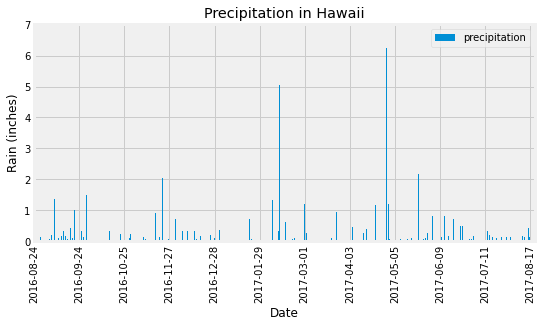

In [86]:
year_df.plot.bar(title="Precipitation in Hawaii", grid=True, xlabel="Date", ylabel="Rain (inches)", figsize=(8,4))

plt.xticks(xticks_locs, xticks_labels)

plt.show()


In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data

year_df.describe()

,precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.id)).all()

[(9)]

In [35]:
# Stations and counts of measurements in descending order.

activity = session.query(func.count(Measurement.date), Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
activity

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [37]:
# "most active" station
station = activity[0][1]
station

'USC00519281'

In [71]:
# lowest, highest, and average temps at the active station

min_temp = session.query(func.min(Measurement.tobs).filter(Measurement.station==station)).all()
max_temp = session.query(func.max(Measurement.tobs).filter(Measurement.station==station)).all()
avg_temp = session.query(func.avg(Measurement.tobs).filter(Measurement.station==station)).all()

print(f"lowest temperature: {min_temp[0][0]}\nhighest temperature: {max_temp[0][0]}\naverage temperature: {avg_temp[0][0]}")


lowest temperature: 54.0
highest temperature: 85.0
average temperature: 71.66378066378067


In [72]:
# the most recent year of measurements from the active station

active_station_measurements = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station==station).\
    filter(Measurement.date > start_date).all()

active_station_measurements

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [87]:
station_temps = pd.DataFrame(active_station_measurements, columns=["date", "temperature"])


In [111]:
temp_min = station_temps["temperature"].min()
temp_max = station_temps["temperature"].max()
bin_size = (temp_max-temp_min)/12
bins = np.arange(temp_min, temp_max, bin_size)
bins

array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81.])

In [114]:
xtick_locs = bins+bin_size/2
xtick_labels = [f"{int(x)} - {int(x+bin_size)}" for x in bins]

<function matplotlib.pyplot.show(close=None, block=None)>

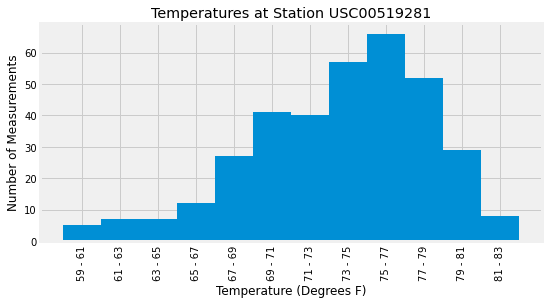

In [121]:
station_temps.hist(column="temperature", bins=12, figsize = (8,4))

plt.title("Temperatures at Station USC00519281")
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Number of Measurements")
plt.xticks(xtick_locs, xtick_labels, rotation = 90)
plt.show

# Close session

In [122]:
# Close Session
session.close()